# GDAL and OGR

[GDAL](https://gdal.org) is the workhorse of geospatial processing. Basically, GDAL offers a common library to access a vast number of formats (if you want to see how vast, [check this](https://gdal.org/formats_list.html)). In addition to letting you open and convert obscure formats to something more useful, a lot of functionality in terms of processing raster data is available (for example, working with projections, combining datasets, accessing remote datasets, etc).

For vector data, the counterpart to GDAL is OGR (which is now a part of the GDAL library anyway), which also supports [many vector formats](https://gdal.org/ogr_formats.html). The combination of both libraries is a very powerful tool to work with geospatial data, not only from Python, but from [many other popular computer languages](https://trac.osgeo.org/gdal/#GDALOGRInOtherLanguages).

In this section, we'll look at combining both raster and vector data to provide a masked dataset ready to use. We will produce a combined dataset of leaf area index (LAI) over the UK derived from the MODIS sensor. The MODIS LAI product is produced every 4 days and it is provided spatially tiled. Each tile covers around 1200 km x 1200 km of the Earth's surface. Below you can see a map showing the MODIS tiling convention.

![MODIS tiles](https://www.researchgate.net/profile/J_Townshend/publication/220473201/figure/fig5/AS:277546596880390@1443183673583/The-global-MODIS-Sinusoidal-tile-grid.png)

Unfortunately, the MODIS tiles system splits the UK in two by the 0 degree meridian, so two tiles are required: `h17v03` and `h18v03`. The latter contains a significant proportion of Western Europe. 

An additional complication is that the MODIS products, being global in extent, use an equal area projection (where the area of the pixel doesn't change, but there can be changes to shapes of e.g. coastlines. See Alaska or Siberia in the map above!).

So, we need to 

1. Stitch together data from two MODIS tiles
2. Find a vector dataset with the boundaries of the UK
3. Ensure that the projection of the vector and raster datasets are compatible
4. Produce a mask, eg, for every pixel that doesn't fall within the UK perimeter, set the pixel to `False`, else set it to `True`.




## The MODIS data

You should by now be able to download MODIS data, but in this case, the data are provided in the `data` folder as files `MCD15A3H.A2018205.h17v03.006.2018210035249.hdf`  and `MCD15A3H.A2018205.h18v03.006.2018210041159.hdf`. We want to select the LAI layers, so let's have a look at the contents of one of the files


In [2]:
import gdal
import numpy as np
import matplotlib.pyplot  as plt
%matplotlib inline

print (gdal.Info("data/MCD15A3H.A2018205.h17v03.006.2018210035249.hdf"))

Driver: HDF4/Hierarchical Data Format Release 4
Files: data/MCD15A3H.A2018205.h17v03.006.2018210035249.hdf
Size is 512, 512
Coordinate System is `'
Metadata:
  ALGORITHMPACKAGEACCEPTANCEDATE=10-01-2004
  ALGORITHMPACKAGEMATURITYCODE=Normal
  ALGORITHMPACKAGENAME=MCDPR_15A3
  ALGORITHMPACKAGEVERSION=6
  ASSOCIATEDINSTRUMENTSHORTNAME.1=MODIS
  ASSOCIATEDINSTRUMENTSHORTNAME.2=MODIS
  ASSOCIATEDPLATFORMSHORTNAME.1=Terra
  ASSOCIATEDPLATFORMSHORTNAME.2=Aqua
  ASSOCIATEDSENSORSHORTNAME.1=MODIS
  ASSOCIATEDSENSORSHORTNAME.2=MODIS
  AUTOMATICQUALITYFLAG.1=Passed
  AUTOMATICQUALITYFLAGEXPLANATION.1=No automatic quality assessment is performed in the PGE
  CHARACTERISTICBINANGULARSIZE500M=15.0
  CHARACTERISTICBINSIZE500M=463.312716527778
  DATACOLUMNS500M=2400
  DATAROWS500M=2400
  DAYNIGHTFLAG=Day
  DESCRREVISION=6.0
  EASTBOUNDINGCOORDINATE=0.016666666662491
  ENGINEERING_DATA=(none-available)

  EXCLUSIONGRINGFLAG.1=N
  GEOANYABNORMAL=False
  GEOESTMAXRMSERROR=50.0
  GLOBALGRIDCOLUMNS500M=864

So we see that the data is in HDF4 format, and that it has a number of layers. The layer we're interested in is `HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018205.h17v03.006.2018210035249.hdf":MOD_Grid_MCD15A3H:Lai_500m`.

<div class="alert alert-block alert-info">
Check you're happy that the other dataset follows the same convention!
</div>

We can now have define GDAL fnames. We can then have a look at the metadata of the LAI dataset itself.

In [8]:
fnames = ["data/MCD15A3H.A2018205.h17v03.006.2018210035249.hdf",
          "data/MCD15A3H.A2018205.h18v03.006.2018210041159.hdf"]
gdal_fnames = [f'HDF4_EOS:EOS_GRID:"{file_name:s}":MOD_Grid_MCD15A3H:Lai_500m'
               for file_name in fnames]

for file_name in gdal_fnames:
    print(f"File: {file_name}")
    print(gdal.Info(file_name))

File: HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018205.h17v03.006.2018210035249.hdf":MOD_Grid_MCD15A3H:Lai_500m
Driver: HDF4Image/HDF4 Dataset
Files: data/MCD15A3H.A2018205.h17v03.006.2018210035249.hdf
Size is 2400, 2400
Coordinate System is:
PROJCS["unnamed",
    GEOGCS["Unknown datum based upon the custom spheroid",
        DATUM["Not specified (based on custom spheroid)",
            SPHEROID["Custom spheroid",6371007.181,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Sinusoidal"],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["Meter",1]]
Origin = (-1111950.519667000044137,6671703.117999999783933)
Pixel Size = (463.312716527916677,-463.312716527916507)
Metadata:
  add_offset=0
  add_offset_err=0
  ALGORITHMPACKAGEACCEPTANCEDATE=10-01-2004
  ALGORITHMPACKAGEMATURITYCODE=Normal
  ALGORITHMPACKAGENAME=MCDPR_15A3
  ALGORITHMPACKAGEVERSION=6
  ASSOCIATEDINSTRUMENTSHORTNAME.1=

So we see that the datasets use the MODIS Sinusoidal projection, and that they have different extents. Also we see that the pixel spacing is around 463m... Let's read in the data...

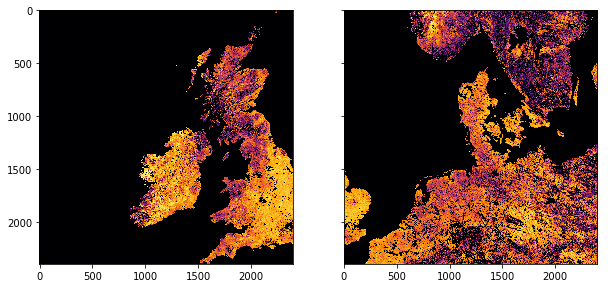

In [99]:
g = gdal.Open(gdal_fnames[0])
lai_h17v03 = g.ReadAsArray()/10. # Divide by 10 to get LAI units of m2/m2
g = gdal.Open(gdal_fnames[1])
lai_h18v03 = g.ReadAsArray()/10. # Divide by 10 to get LAI units of m2/m2

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                       figsize=(10,5))

axs[0].imshow(lai_h17v03, interpolation="nearest", vmin=0, vmax=4,
             cmap=plt.cm.inferno_r)
axs[1].imshow(lai_h18v03, interpolation="nearest", vmin=0, vmax=4,
             cmap=plt.cm.inferno_r)

You may want to stitch things together "by hand"...

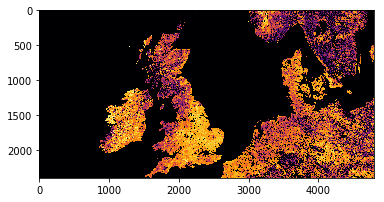

In [100]:
lai_stich = np.c_[ lai_h17v03, lai_h18v03]
plt.imshow(lai_stich, interpolation="nearest", vmin=0, vmax=4,
          cmap=plt.cm.inferno_r)

However, this is problematic if you want to mosaic many tiles, as you need to read in all the data in memory, and some tiles may be missing. GDAL allows you to create a mosaic as [virtual file format](https://www.gdal.org/gdal_vrttut.html), using gdal.BuildVRT (check the documentation). This function takes two inputs: the output filename (`stitch_up.vrt`) and a set of GDAL format filenames. It returns the open output dataset, so that we can check what it looks like with e.g. `gdal.Info`

In [18]:
stitch_vrt = gdal.BuildVRT("stitch_up.vrt", gdal_fnames)
print(gdal.Info(stitch_vrt))


Driver: VRT/Virtual Raster
Files: stitch_up.vrt
Size is 4800, 2400
Coordinate System is:
PROJCS["unnamed",
    GEOGCS["Unknown datum based upon the custom spheroid",
        DATUM["Not specified (based on custom spheroid)",
            SPHEROID["Custom spheroid",6371007.181,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Sinusoidal"],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["Meter",1]]
Origin = (-1111950.519667000044137,6671703.117999999783933)
Pixel Size = (463.312716527916677,-463.312716527916507)
Corner Coordinates:
Upper Left  (-1111950.520, 6671703.118) ( 20d 0' 0.00"W, 60d 0' 0.00"N)
Lower Left  (-1111950.520, 5559752.598) ( 15d33'26.06"W, 50d 0' 0.00"N)
Upper Right ( 1111950.520, 6671703.118) ( 20d 0' 0.00"E, 60d 0' 0.00"N)
Lower Right ( 1111950.520, 5559752.598) ( 15d33'26.06"E, 50d 0' 0.00"N)
Center      (       0.000, 6115727.858) (  0d 0' 0.01"E, 55d 

So we see that we now have 4800 columns by 2400 rows dataset, centered around 55 degrees North, 0 degrees W (somewhere in the North Sea, East of Newcastle). Let's plot the data...

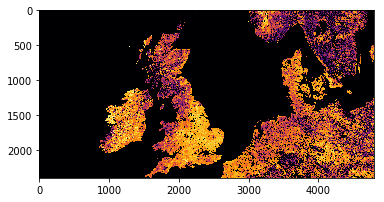

In [101]:
# stitch_vrt is an already opened GDAL dataset, needs to be read in
plt.imshow(sticth_vrt.ReadAsArray()/10.,
           interpolation="nearest", vmin=0, vmax=4, 
          cmap=plt.cm.inferno_r)

## The country borders dataset

A number of vectors with countries and administrative subdivisions are available. The [TM_WORLD_BORDERS shapefile](http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip) is popular and in the public domain. You can see it, and have a look at the data [here](https://koordinates.com/layer/7354-tm-world-borders-03/). We need to download and unzip this file... We'll use requests as before, and we'll unpack the zip file using [`shutil.unpack_archive`](https://docs.python.org/3/library/shutil.html#shutil.unpack_archive)

In [29]:
import requests
import shutil 

tm_borders_url = "http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip"

r = requests.get(tm_borders_url)
with open("data/TM_WORLD_BORDERS-0.3.zip", 'wb') as fp:
    fp.write (r.content)

shutil.unpack_archive("data/TM_WORLD_BORDERS-0.3.zip",
                     extract_dir="data/")

Make sure you have the relevant files available in your `data` folder! We can then inspect the dataset using the command line tool `ogrinfo`. We can call it from the shell by appending the `!` symbol, and select that we want to check only the data for the UK (stored in the `FIPS` field with value `UK`):

<div class="alert alert-block alert-info">
  It is worth noting that using OGR's queries trying to match a string, the string needs to be surrounded by <pre>'</pre>. You can also use more complicated SQL queries if you wanted to.
</div>

In [38]:
!ogrinfo -al -where "FIPS='UK'" data/TM_WORLD_BORDERS-0.3.shp 

INFO: Open of `data/TM_WORLD_BORDERS-0.3.shp'
      using driver `ESRI Shapefile' successful.

Layer name: TM_WORLD_BORDERS-0.3
Metadata:
  DBF_DATE_LAST_UPDATE=2008-07-30
Geometry: Polygon
Feature Count: 1
Extent: (-180.000000, -90.000000) - (180.000000, 83.623596)
Layer SRS WKT:
GEOGCS["GCS_WGS_1984",
    DATUM["WGS_1984",
        SPHEROID["WGS_84",6378137.0,298.257223563]],
    PRIMEM["Greenwich",0.0],
    UNIT["Degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
FIPS: String (2.0)
ISO2: String (2.0)
ISO3: String (3.0)
UN: Integer (3.0)
NAME: String (50.0)
AREA: Integer (7.0)
POP2005: Integer64 (10.0)
REGION: Integer (3.0)
SUBREGION: Integer (3.0)
LON: Real (8.3)
LAT: Real (7.3)
OGRFeature(TM_WORLD_BORDERS-0.3):206
  FIPS (String) = UK
  ISO2 (String) = GB
  ISO3 (String) = GBR
  UN (Integer) = 826
  NAME (String) = United Kingdom
  AREA (Integer) = 24193
  POP2005 (Integer64) = 60244834
  REGION (Integer) = 150
  SUBREGION (Integer) = 154
  LON (Real) = -1.600
  LAT (Real) =

We inmediately see that the coordinates for the UK are in several polygons, and in WGS84 (Latitude and Longitude in decimal degrees). This is incompatible with the MODIS data.

We can use GDAL to quickly apply the vector feature for the UK as a mask. There are several ways of doing this, but the simplest is to use [gdal.Warp](https://www.gdal.org/gdalwarp.html) (the link is to the command line tool). In this case, we just want to create:

* an in-memory (i.e. not saved to a file) dataset. We can use the format `MEM`, so no file is written out
* where the FIPS field is equal to "UK", we want the LAI to show, elsewhere, we set it to (e.g.) "no data" (e.g. -999)


The mosaicked version of the MODIS LAI product is in file `stitch_up.vrt`. Since we're not saving the output to a file (`MEM` output option), we can leave the output as an empty string `""`. The shapefile comes with the `cutline` options:

* `cutlineDSName` that's the name of the vector file we want to use as a cutline
* `cutlineWhere` that's the selection statement for the attribute table in the dataset. 

To set the no data value to 200, we can use the option `dstNodata=200`. This is because very large values in the LAI product are already indicated to be invalid.

We can then just very quickly perform this and check...

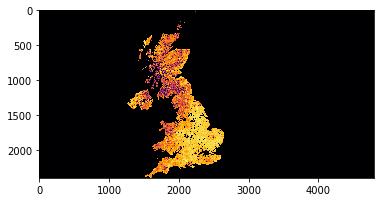

In [78]:
g = gdal.Warp("", "stitch_up.vrt",
         format = 'MEM',dstNodata=200,
          cutlineDSName = 'data/TM_WORLD_BORDERS-0.3.shp', cutlineWhere = "FIPS='UK'")
masked_lai = g.ReadAsArray()/10.
plt.imshow(masked_lai, interpolation="nearest", vmin=0, vmax=6, 
          cmap=plt.cm.inferno_r)

So that works as expected, but since we haven't actually told GDAL anything about the output (other than apply the mask), we still have a 4800 pixel wide dataset. You may want to crop it by looking for where the original dataset is  *not* -999, or in fact, for pixels that are bigger than 0. You'll be pleased to know that this is a great slicing application!

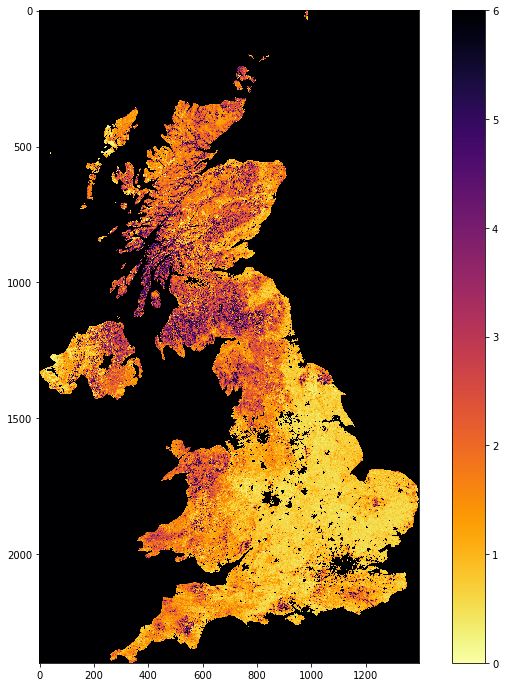

In [81]:
lai = g.ReadAsArray()
mask = np.nonzero(lai < 20)
min_y = mask[0].min()
max_y = mask[0].max() + 1

min_x = mask[1].min()
max_x = mask[1].max() + 1

plt.figure(figsize=(12,12))
plt.imshow( lai[min_y:max_y,
               min_x:max_x]/10., vmin=0, vmax=6,
           cmap=plt.cm.inferno_r)
plt.colorbar()


## Putting it all together

The previous steps can be put together in a function. It is even possible to simplify things a bit more by not even storing the name of the stitiched up VRT file:

## Exercises

* Put everything together as a function
* Mask pixels outside the Netherlands
* Mask pixels outside Ireland


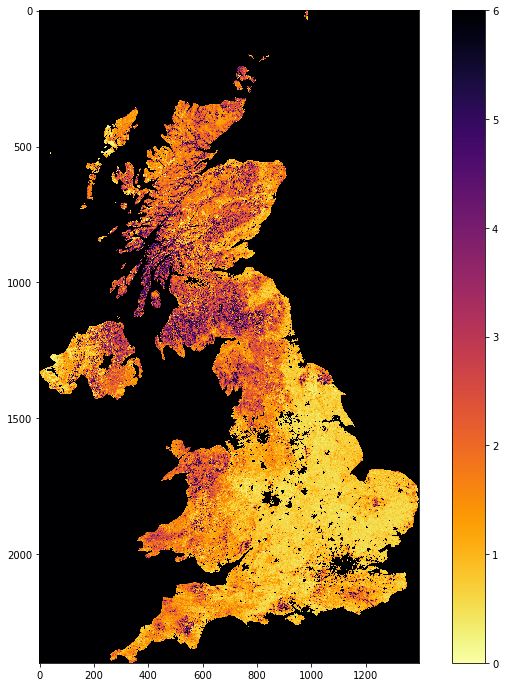

In [90]:
def mosaic_and_mask_data(gdal_fnames, vector_file, vector_where):
    stitch_vrt = gdal.BuildVRT("", gdal_fnames)
    g = gdal.Warp("", stitch_vrt,
                 format = 'MEM', dstNodata=200,
                  cutlineDSName = vector_file,
                  cutlineWhere = vector_where)

    return g

g = mosaic_and_mask_data(gdal_fnames, "data/TM_WORLD_BORDERS-0.3.shp",
                         "FIPS='UK'")
lai = g.ReadAsArray()
mask = np.nonzero(lai < 200)
min_y = mask[0].min()
max_y = mask[0].max() + 1

min_x = mask[1].min()
max_x = mask[1].max() + 1

plt.figure(figsize=(12,12))
plt.imshow( lai[min_y:max_y,
               min_x:max_x]/10., vmin=0, vmax=6,
           cmap=plt.cm.inferno_r)
plt.colorbar()


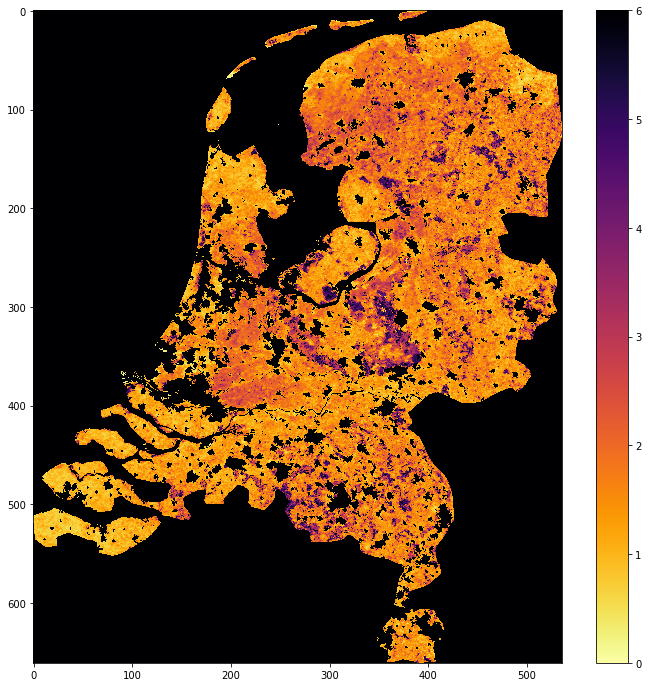

In [98]:
g = mosaic_and_mask_data(gdal_fnames, "data/TM_WORLD_BORDERS-0.3.shp",
                         "FIPS='NL'")
lai = g.ReadAsArray()
mask = np.nonzero(lai < 200)
min_y = mask[0].min()
max_y = mask[0].max() + 1

min_x = mask[1].min()
max_x = mask[1].max() + 1

plt.figure(figsize=(12,12))
plt.imshow( lai[min_y:max_y,
               min_x:max_x]/10., vmin=0, vmax=6,
           cmap=plt.cm.inferno_r)
plt.colorbar()